# **ISOT Dataset and Embeddings**

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
path = '/content/drive/MyDrive/NEWS_DATASET/final.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
def strip(row):
  return row['text'].strip('"')

df['text'] = df.apply(strip,axis=1)
df.head()

,title,text,label
0,China says Trump plan to move embassy in Israe...,BEIJING (Reuters) - China expressed concern on...,true
1,India says ready for stronger U.S. ties after ...,NEW DELHI (Reuters) - India stood ready to fur...,true
2,A PRESIDENT WHO’S UNSERIOUS AND UNDIGNIFIED…DO...,America deserves so much better and should get...,fake
3,#DNC GIVES ANTI-HILLARY Dems Free Speech Cage ...,"It s just cleaner that way You know, keeping a...",fake
4,Castro meets North Korea minister amid hope Cu...,HAVANA (Reuters) - Cuban President Raul Castro...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['label']
labels_encoded = label_encoder.fit_transform(label)
df['label'] = labels_encoded
df.head()

,title,text,label
0,China says Trump plan to move embassy in Israe...,BEIJING (Reuters) - China expressed concern on...,1
1,India says ready for stronger U.S. ties after ...,NEW DELHI (Reuters) - India stood ready to fur...,1
2,A PRESIDENT WHO’S UNSERIOUS AND UNDIGNIFIED…DO...,America deserves so much better and should get...,0
3,#DNC GIVES ANTI-HILLARY Dems Free Speech Cage ...,"It s just cleaner that way You know, keeping a...",0
4,Castro meets North Korea minister amid hope Cu...,HAVANA (Reuters) - Cuban President Raul Castro...,1


## **DistilBERT - Train**

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers[:-2]:
    layer.trainable = False


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, df['label'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 2
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/2
17959/17959 [==============================] - 1005s 55ms/step - loss: 0.5155 - accuracy: 0.8732
Epoch 2/2
17959/17959 [==============================] - 966s 54ms/step - loss: 0.3353 - accuracy: 0.9249


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

4490/4490 [==============================] - 222s 49ms/step - loss: 0.2762 - accuracy: 0.9339


In [ ]:
print(benchmarks)

{'loss': 0.2762000262737274, 'accuracy': 0.933853030204773}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 1,538
Non-trainable params: 66,953,472
_________________________________________________________________


In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/NEWS_DATASET/distil_text')

In [ ]:
!echo 'clear cache'

clear cache


## **DistilBERT embeddings**

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

#### ISOT Title Embeddings DistilBERT

In [ ]:
#το συγκεκριμένο τμήμα είναι χρονοβόρο οπότε καλό θα ήταν να χρησιμοποιούνται τα αποθηκευμένα αρχεία που έχουμε δημιουργήσει (embeddings.npy,labels.npy)
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['title'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 44898/44898 [1:24:02<00:00,  8.90it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
labels = df['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy', labels)

#### ISOT Text Embeddings DistilBERT

In [ ]:
copy = df.copy()

In [ ]:
from tqdm import tqdm
batch_size = 1
text = copy['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(text), batch_size)):
    batch_titles = text[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 44898/44898 [1:30:04<00:00,  8.31it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
copy['label'] = label_encoder.fit_transform(copy['label'])
labels = copy['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy', labels)

#### ISOT Text Max Worth Embeddings DistilBERT

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import json
from tqdm import tqdm
def get_sentence_scores(sentences, api_key):
  api_endpoint = "https://idir.uta.edu/claimbuster/api/v2/score/text/sentences/"
  request_headers = {"x-api-key": api_key}
  payload = {"input_text": sentences}
  api_response = requests.post(url=api_endpoint, json=payload, headers=request_headers)
  return api_response.json()


In [ ]:
def max_worth(text,limit):
  api_key = '62ed42f8ab5d412facdc20e76e7dfe50'
  c = get_sentence_scores(text,api_key)
  c = sorted(c['results'], key=lambda x: float(x['score']), reverse=True)
  for res in c:
    res['word_count'] = len(res['text'].split())

  total_words = 0
  last_index = -1

  for i, item in enumerate(c):
    text = item['text']
    word_count = len(text.split())
    if total_words + word_count > 450:
      break
    total_words += word_count
    last_index = i

  c = c[:last_index+1]
  c = sorted(c, key=lambda x: x['index'])
  c = ' '.join([result['text'] for result in c])

  return c

In [ ]:
df['max'] = tqdm(df['text'].apply(max_worth,limit=450))


100%|██████████| 44898/44898 [00:00<00:00, 366541.57it/s]


In [ ]:
df.to_csv('/content/drive/My Drive/NEWS_DATASET/final_max.csv', index=False)

In [ ]:
df.head()

,title,text,label,max
0,China says Trump plan to move embassy in Israe...,BEIJING (Reuters) - China expressed concern on...,1,BEIJING (Reuters) - China expressed concern on...
1,India says ready for stronger U.S. ties after ...,NEW DELHI (Reuters) - India stood ready to fur...,1,NEW DELHI (Reuters) - India stood ready to fur...
2,A PRESIDENT WHO’S UNSERIOUS AND UNDIGNIFIED…DO...,America deserves so much better and should get...,0,Obama has been so undignified throughout his p...
3,#DNC GIVES ANTI-HILLARY Dems Free Speech Cage ...,"It s just cleaner that way You know, keeping a...",0,"It s just cleaner that way You know, keeping a..."
4,Castro meets North Korea minister amid hope Cu...,HAVANA (Reuters) - Cuban President Raul Castro...,1,HAVANA (Reuters) - Cuban President Raul Castro...


450


Text(0.5, 1.0, 'Text Length distribution (Max_Worth)')

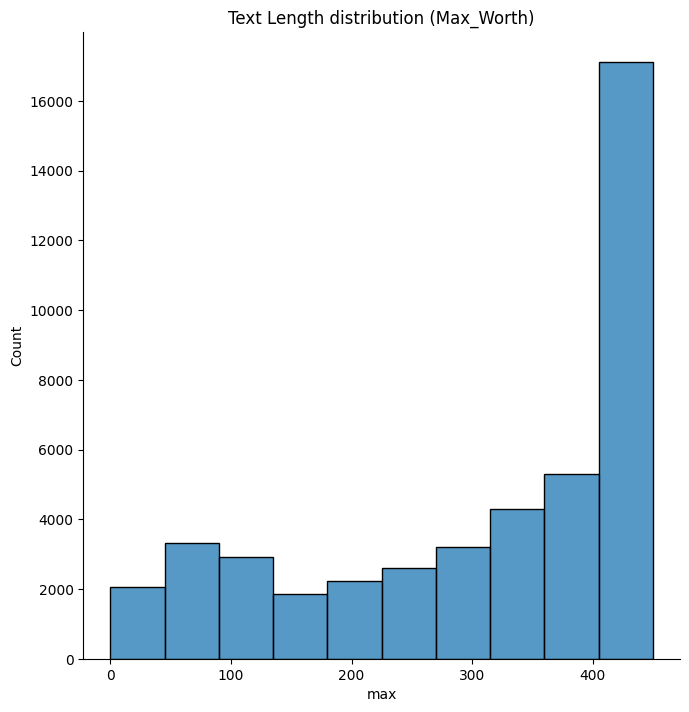

In [ ]:
word_counts = df['max'].apply(lambda x: len(x.split()))
print(word_counts.max())
sns.displot(word_counts, kde=False, bins=10, height=7, aspect=1)
plt.title('Text Length distribution (Max_Worth)')

In [ ]:
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
model_distil = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/NEWS_DATASET/distil_text',num_labels=2,output_hidden_states=True)

Some layers from the model checkpoint at /content/drive/MyDrive/NEWS_DATASET/distil_text were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NEWS_DATASET/distil_text and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
path = '/content/drive/MyDrive/NEWS_DATASET/final_max.csv'
copy = pd.read_csv(path,delimiter=',')

In [ ]:
from tqdm import tqdm
batch_size = 1
text = copy['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(text), batch_size)):
    batch_titles = str(text[i:i+batch_size])

    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 44898/44898 [1:24:07<00:00,  8.89it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
label_encoder = LabelEncoder()
copy['label'] = label_encoder.fit_transform(copy['label'])
labels = copy['label'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.1915 - accuracy: 0.9247 - val_loss: 0.1514 - val_accuracy: 0.9459
Epoch 2/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.1262 - accuracy: 0.9536 - val_loss: 0.1312 - val_accuracy: 0.9481
Epoch 3/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.1114 - accuracy: 0.9591 - val_loss: 0.1024 - val_accuracy: 0.9604
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0998 - accuracy: 0.9637 - val_loss: 0.1056 - val_accuracy: 0.9608
Epoch 5/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0922 - accuracy: 0.9667 - val_loss: 0.1022 - val_accuracy: 0.9621
Epoch 6/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0832 - accuracy: 0.9675 - val_loss: 0.1055 - val_accuracy: 0.9612
Epoch 7/10
2245/2245 [==============================] - 12s 6ms/step - loss: 0.0760 - accuracy: 0.9719 - val_loss: 0.1000 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 3ms/step
Test Accuracy: 0.9671491980552673
Test F1 Score: 0.9662200847360587
Test Recall: 0.9663307375171782
Precision: 0.9661094572933364


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [ ]:
model.save('cnn_distilbert_title.h5')

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 1s 3ms/step
[[4466  148]
 [ 147 4219]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

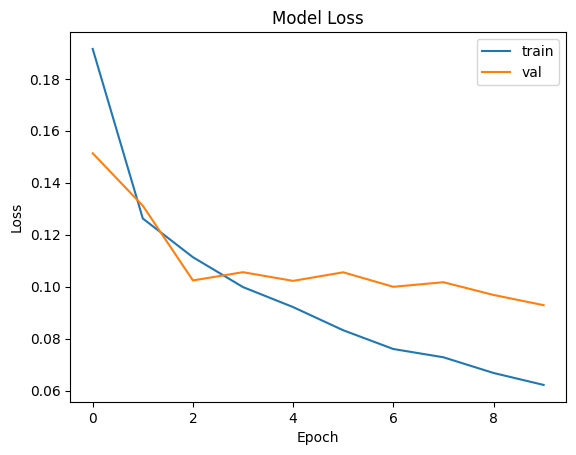

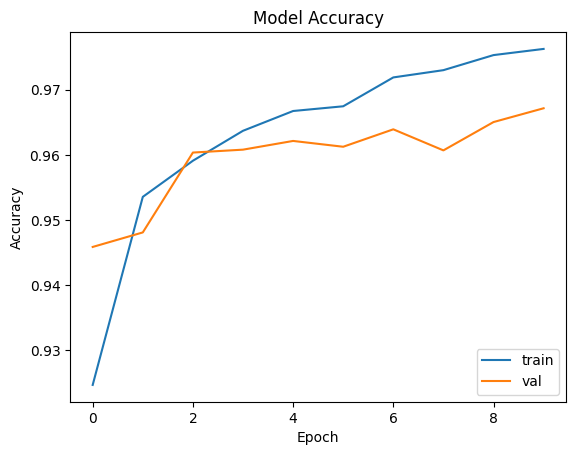

281/281 [==============================] - 1s 2ms/step


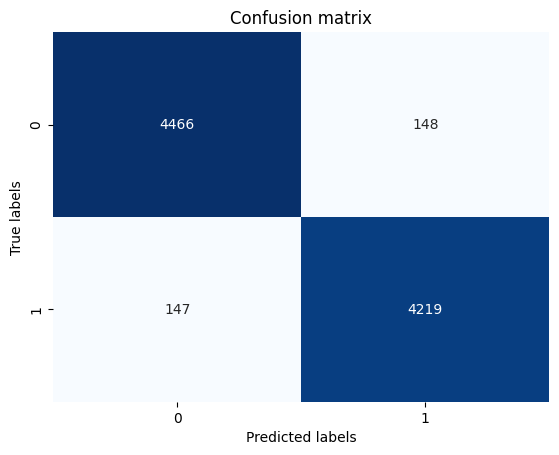

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4614
           1       0.97      0.97      0.97      4366

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 37s 14ms/step - loss: 0.2403 - accuracy: 0.9320 - val_loss: 0.1427 - val_accuracy: 0.9493
Epoch 2/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.1382 - accuracy: 0.9499 - val_loss: 0.1612 - val_accuracy: 0.9448
Epoch 3/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.1225 - accuracy: 0.9566 - val_loss: 0.3895 - val_accuracy: 0.8621
Epoch 4/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.1102 - accuracy: 0.9606 - val_loss: 0.1109 - val_accuracy: 0.9619
Epoch 5/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.1023 - accuracy: 0.9629 - val_loss: 0.1154 - val_accuracy: 0.9615
Epoch 6/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0944 - accuracy: 0.9656 - val_loss: 0.1003 - val_accuracy: 0.9665
Epoch 7/10
2245/2245 [==============================] - 28s 12ms/step - loss: 0.0884 - accuracy: 0.9683 - val_loss: 0.0976 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0963 - accuracy: 0.9668 - 2s/epoch - 6ms/step
281/281 [==============================] - 2s 5ms/step
Test Accuracy: 0.966815173625946
Test F1 Score: 0.9662361205529119
Test Recall: 0.9766376546037563
Precision: 0.9560538116591928


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 378, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

In [ ]:
model2.save('lstm_base.h5')

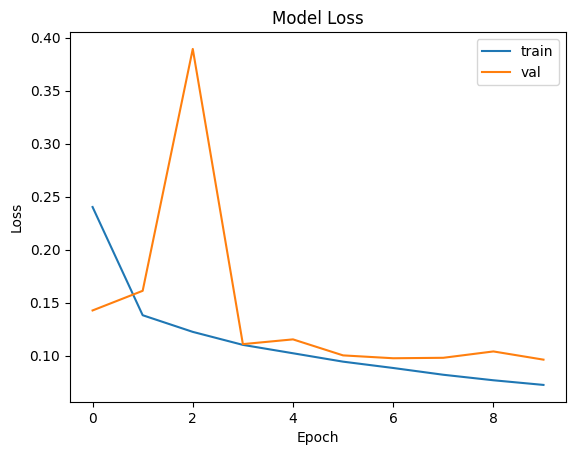

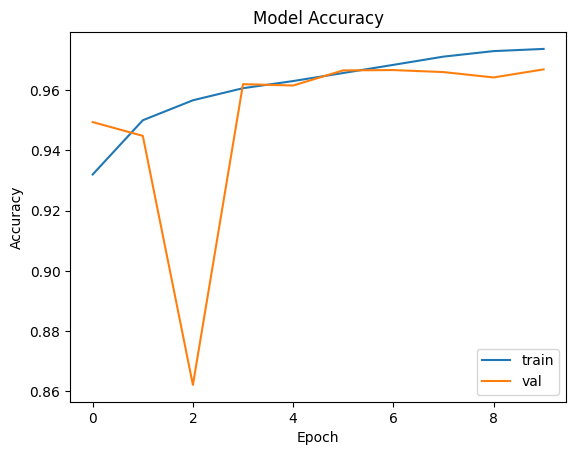

281/281 [==============================] - 2s 6ms/step


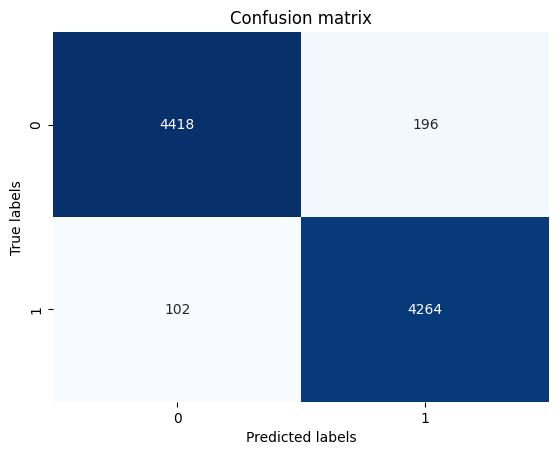

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4614
           1       0.96      0.98      0.97      4366

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 26s 12ms/step - loss: 0.1516 - accuracy: 0.9443 - val_loss: 0.1145 - val_accuracy: 0.9550
Epoch 2/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.1169 - accuracy: 0.9564 - val_loss: 0.0988 - val_accuracy: 0.9627
Epoch 3/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.1005 - accuracy: 0.9630 - val_loss: 0.0974 - val_accuracy: 0.9648
Epoch 4/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0863 - accuracy: 0.9683 - val_loss: 0.1024 - val_accuracy: 0.9659
Epoch 5/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0799 - accuracy: 0.9719 - val_loss: 0.0879 - val_accuracy: 0.9645
Epoch 6/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0694 - accuracy: 0.9741 - val_loss: 0.0883 - val_accuracy: 0.9677
Epoch 7/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0635 - accuracy: 0.9768 - val_loss: 0.1171 -

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.1058 - accuracy: 0.9687 - 2s/epoch - 7ms/step
281/281 [==============================] - 2s 5ms/step
Test Accuracy: 0.9687082171440125
Test F1 Score: 0.9675031802937435
Test Recall: 0.9580852038479157
Precision: 0.9771081523008642


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

In [ ]:
model3.save('fake_bert.h5')

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 1s 5ms/step
[[4516   98]
 [ 183 4183]]


# **CNN-DistilBERT-Text**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
# build the model
model4 = Sequential()
model4.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size=5))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(MaxPooling1D(pool_size=5))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))


In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 35s 10ms/step - loss: 0.1303 - accuracy: 0.9492 - val_loss: 0.0551 - val_accuracy: 0.9806
Epoch 2/10
2245/2245 [==============================] - 17s 8ms/step - loss: 0.0576 - accuracy: 0.9801 - val_loss: 0.0464 - val_accuracy: 0.9840
Epoch 3/10
2245/2245 [==============================] - 18s 8ms/step - loss: 0.0482 - accuracy: 0.9826 - val_loss: 0.0422 - val_accuracy: 0.9846
Epoch 4/10
2245/2245 [==============================] - 15s 6ms/step - loss: 0.0415 - accuracy: 0.9863 - val_loss: 0.0396 - val_accuracy: 0.9870
Epoch 5/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0371 - accuracy: 0.9874 - val_loss: 0.0385 - val_accuracy: 0.9875
Epoch 6/10
2245/2245 [==============================] - 22s 10ms/step - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.0452 - val_accuracy: 0.9870
Epoch 7/10
2245/2245 [==============================] - 22s 10ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0433 - val

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 3ms/step
Test Accuracy: 0.988418698310852
Test F1 Score: 0.9881575950808473
Test Recall: 0.9938158497480531
Precision: 0.9825634057971014


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [ ]:
model4.save('cnn_distilbert_text.h5')

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 1s 2ms/step
[[4537   77]
 [  27 4339]]


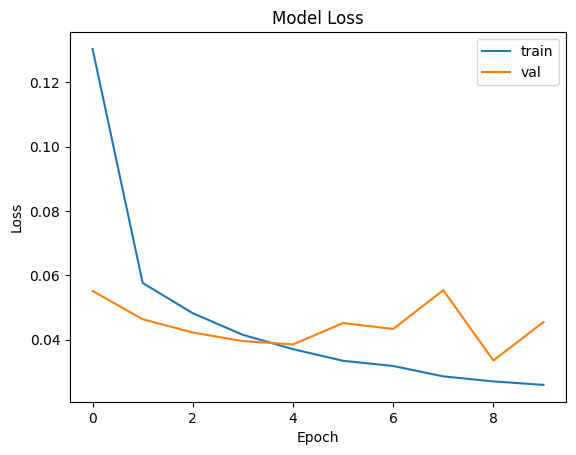

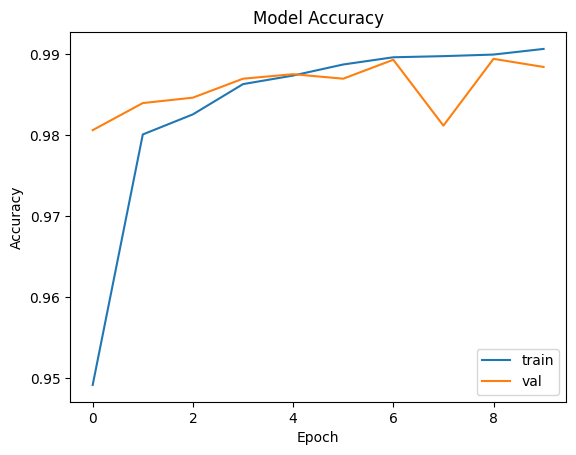

281/281 [==============================] - 1s 2ms/step


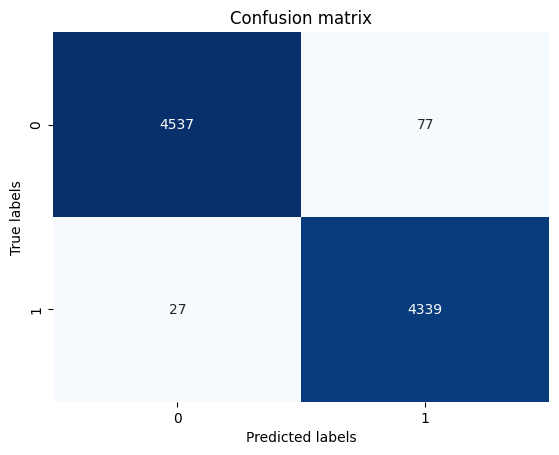

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4614
           1       0.98      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history4,model4)

# **LSTM-DistilBERT-Text**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(LSTM(64, return_sequences=True))
model5.add(Dropout(0.2))
model5.add(BatchNormalization())
model5.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 37s 14ms/step - loss: 0.1601 - accuracy: 0.9607 - val_loss: 0.7612 - val_accuracy: 0.7453
Epoch 2/10
2245/2245 [==============================] - 32s 14ms/step - loss: 0.0702 - accuracy: 0.9775 - val_loss: 0.0698 - val_accuracy: 0.9758
Epoch 3/10
2245/2245 [==============================] - 31s 14ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0938 - val_accuracy: 0.9659
Epoch 4/10
2245/2245 [==============================] - 30s 14ms/step - loss: 0.0493 - accuracy: 0.9843 - val_loss: 0.1406 - val_accuracy: 0.9497
Epoch 5/10
2245/2245 [==============================] - 32s 14ms/step - loss: 0.0439 - accuracy: 0.9856 - val_loss: 0.0672 - val_accuracy: 0.9788
Epoch 6/10
2245/2245 [==============================] - 32s 14ms/step - loss: 0.0373 - accuracy: 0.9879 - val_loss: 0.0808 - val_accuracy: 0.9726
Epoch 7/10
2245/2245 [==============================] - 30s 13ms/step - loss: 0.0354 - accuracy: 0.9885 - val_loss: 0.0506 -

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0335 - accuracy: 0.9899 - 2s/epoch - 6ms/step
281/281 [==============================] - 2s 5ms/step
Test Accuracy: 0.9898663759231567
Test F1 Score: 0.9895940537449972
Test Recall: 0.9910673385249656
Precision: 0.98812514272665


In [ ]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 378, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

In [ ]:
model5.save('lstm_base_text.h5')

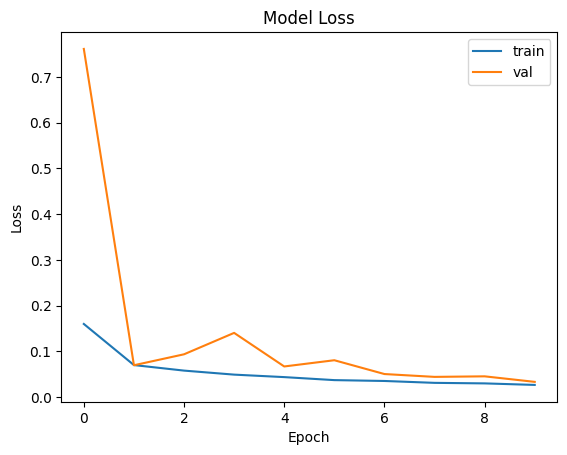

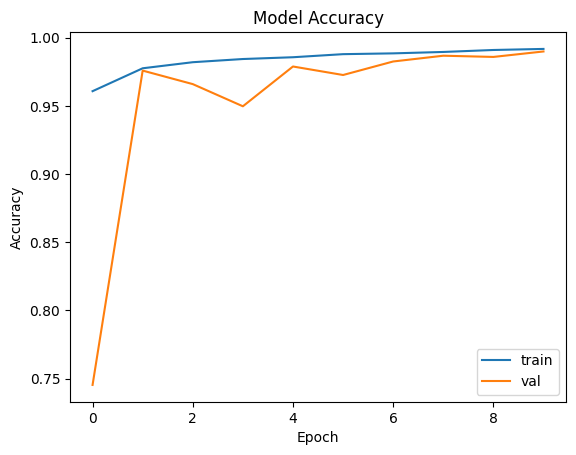

281/281 [==============================] - 2s 6ms/step


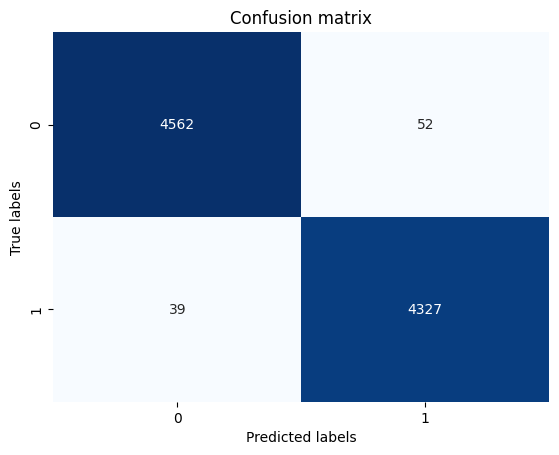

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4614
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history5,model5)

# **FakeBERT-DistilBERT-Text**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model6 = Model(inputs=inputs, outputs=output)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 1177s 522ms/step - loss: 0.1090 - accuracy: 0.9596 - val_loss: 0.0546 - val_accuracy: 0.9821
Epoch 2/10
2245/2245 [==============================] - 1127s 502ms/step - loss: 0.0580 - accuracy: 0.9805 - val_loss: 0.0453 - val_accuracy: 0.9841
Epoch 3/10
2245/2245 [==============================] - 1113s 496ms/step - loss: 0.0465 - accuracy: 0.9835 - val_loss: 0.0394 - val_accuracy: 0.9873
Epoch 4/10
2245/2245 [==============================] - 1161s 517ms/step - loss: 0.0419 - accuracy: 0.9862 - val_loss: 0.0360 - val_accuracy: 0.9889
Epoch 5/10
2245/2245 [==============================] - 1131s 504ms/step - loss: 0.0367 - accuracy: 0.9879 - val_loss: 0.0414 - val_accuracy: 0.9867
Epoch 6/10
2245/2245 [==============================] - 1161s 517ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.0523 - val_accuracy: 0.9856
Epoch 7/10
2245/2245 [==============================] - 1158s 516ms/step - loss: 0.0288 - accuracy: 0.9903

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 51s - loss: 0.0679 - accuracy: 0.9865 - 51s/epoch - 180ms/step
281/281 [==============================] - 53s 186ms/step
Test Accuracy: 0.9865255951881409
Test F1 Score: 0.9860034702139966
Test Recall: 0.9761795693999084
Precision: 0.996027109137649


In [ ]:
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

In [ ]:
model6.save('fake_bert.h5')

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 61s 217ms/step
[[4597   17]
 [ 104 4262]]


# **CNN-DistilBERT-Max Worth**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
# build the model
model7 = Sequential()
model7.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model7.add(MaxPooling1D(pool_size=5))
model7.add(Conv1D(128, 5, activation='relu'))
model7.add(MaxPooling1D(pool_size=5))
model7.add(Conv1D(128, 5, activation='relu'))
model7.add(Flatten())
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.5))
model7.add(Dense(1, activation='sigmoid'))


In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history7 = model7.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 23s 6ms/step - loss: 0.1370 - accuracy: 0.9471 - val_loss: 0.0603 - val_accuracy: 0.9792
Epoch 2/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0635 - accuracy: 0.9795 - val_loss: 0.0562 - val_accuracy: 0.9804
Epoch 3/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0531 - accuracy: 0.9822 - val_loss: 0.0442 - val_accuracy: 0.9845
Epoch 4/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0453 - accuracy: 0.9850 - val_loss: 0.0558 - val_accuracy: 0.9803
Epoch 5/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0400 - accuracy: 0.9862 - val_loss: 0.0516 - val_accuracy: 0.9837
Epoch 6/10
2245/2245 [==============================] - 14s 6ms/step - loss: 0.0367 - accuracy: 0.9869 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 7/10
2245/2245 [==============================] - 13s 6ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0377 - val_ac

In [ ]:
test_loss, test_acc = model7.evaluate(test_embeddings, test_labels)

y_pred = model7.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

281/281 [==============================] - 1s 2ms/step
Test Accuracy: 0.9881960153579712
Test F1 Score: 0.9878690775921263
Test Recall: 0.9885478699038021
Precision: 0.9871912168344007


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [ ]:
model7.save('cnn_distilbert_textmax.h5')

In [ ]:
y_pred = model7.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 1s 2ms/step
[[4558   56]
 [  50 4316]]


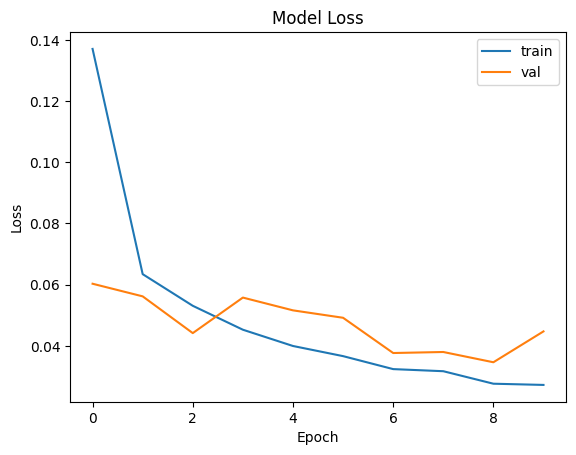

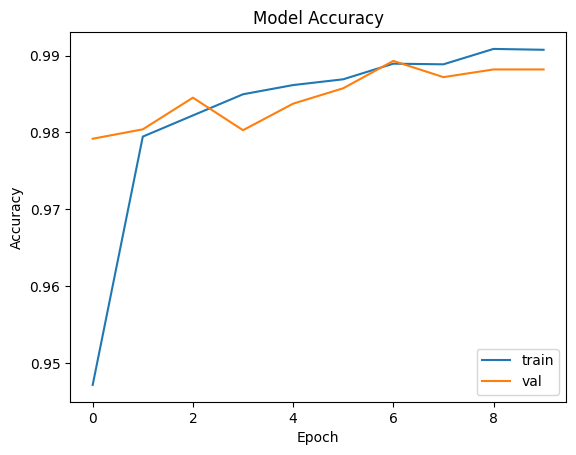

281/281 [==============================] - 1s 3ms/step


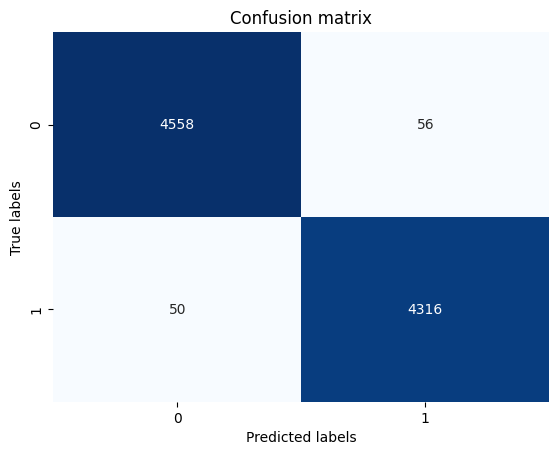

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4614
           1       0.99      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history7,model7)

# **LSTM-DistilBERT-Max Worth**

In [ ]:
model8 = Sequential()
model8.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model8.add(MaxPooling1D(pool_size=2))
model8.add(Conv1D(64, 5, activation='relu'))
model8.add(MaxPooling1D(pool_size=2))
model8.add(Conv1D(64, 5, activation='relu'))
model8.add(LSTM(64, return_sequences=True))
model8.add(Dropout(0.2))
model8.add(BatchNormalization())
model8.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model8.add(Dropout(0.2))
model8.add(Flatten())
model8.add(Dense(1, activation='sigmoid'))

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history8 = model8.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 36s 13ms/step - loss: 0.1741 - accuracy: 0.9549 - val_loss: 0.0784 - val_accuracy: 0.9753
Epoch 2/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0750 - accuracy: 0.9764 - val_loss: 0.3143 - val_accuracy: 0.8880
Epoch 3/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0637 - accuracy: 0.9805 - val_loss: 0.0638 - val_accuracy: 0.9813
Epoch 4/10
2245/2245 [==============================] - 31s 14ms/step - loss: 0.0543 - accuracy: 0.9829 - val_loss: 0.1271 - val_accuracy: 0.9563
Epoch 5/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0489 - accuracy: 0.9850 - val_loss: 0.0506 - val_accuracy: 0.9855
Epoch 6/10
2245/2245 [==============================] - 29s 13ms/step - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.0493 - val_accuracy: 0.9866
Epoch 7/10
2245/2245 [==============================] - 28s 13ms/step - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.0569 -

In [ ]:
test_loss, test_acc = model8.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model8.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0503 - accuracy: 0.9859 - 2s/epoch - 6ms/step
281/281 [==============================] - 2s 5ms/step
Test Accuracy: 0.9858574867248535
Test F1 Score: 0.9855599772598067
Test Recall: 0.9926706367384334
Precision: 0.9785504628584331


In [ ]:
model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 378, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

In [ ]:
model8.save('lstm_base_textmax.h5')

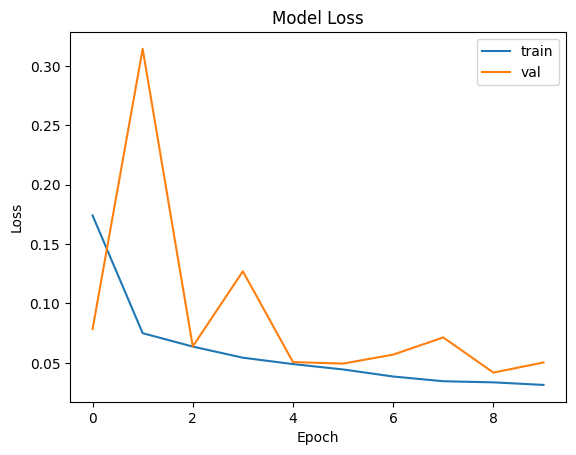

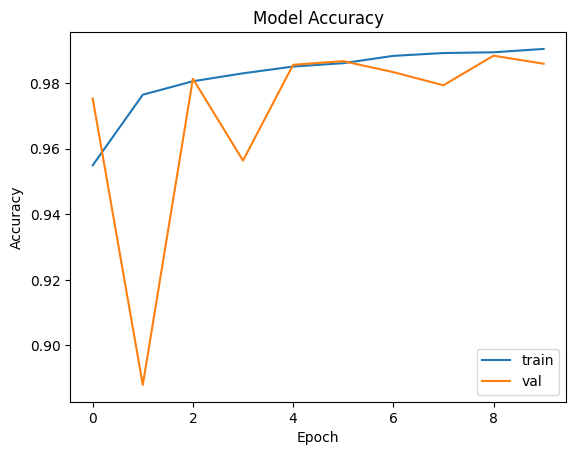

281/281 [==============================] - 1s 5ms/step


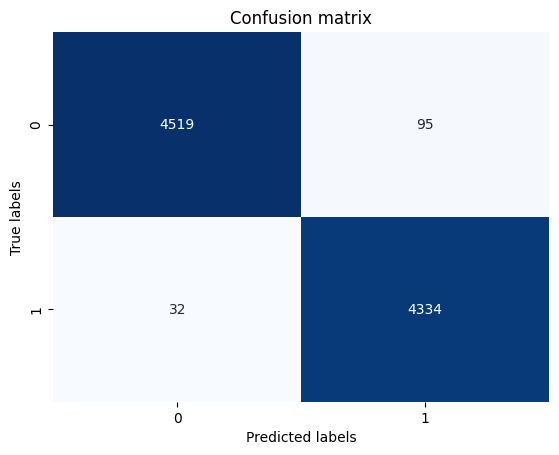

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4614
           1       0.98      0.99      0.99      4366

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
plot_history(history8,model8)

# **FakeBERT-DistilBERT-Max Worth**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model9 = Model(inputs=inputs, outputs=output)

In [ ]:
model9.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history9 = model9.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
2245/2245 [==============================] - 30s 12ms/step - loss: 0.1180 - accuracy: 0.9565 - val_loss: 0.0765 - val_accuracy: 0.9718
Epoch 2/10
2245/2245 [==============================] - 26s 11ms/step - loss: 0.0635 - accuracy: 0.9779 - val_loss: 0.0915 - val_accuracy: 0.9694
Epoch 3/10
2245/2245 [==============================] - 26s 11ms/step - loss: 0.0521 - accuracy: 0.9820 - val_loss: 0.0481 - val_accuracy: 0.9847
Epoch 4/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0461 - accuracy: 0.9847 - val_loss: 0.0764 - val_accuracy: 0.9790
Epoch 5/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0392 - accuracy: 0.9861 - val_loss: 0.0432 - val_accuracy: 0.9871
Epoch 6/10
2245/2245 [==============================] - 26s 11ms/step - loss: 0.0359 - accuracy: 0.9875 - val_loss: 0.0817 - val_accuracy: 0.9808
Epoch 7/10
2245/2245 [==============================] - 25s 11ms/step - loss: 0.0338 - accuracy: 0.9885 - val_loss: 0.0435 -

In [ ]:
test_loss, test_acc = model9.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model9.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 2s - loss: 0.0614 - accuracy: 0.9803 - 2s/epoch - 6ms/step
281/281 [==============================] - 1s 5ms/step
Test Accuracy: 0.9802895188331604
Test F1 Score: 0.9794114225892753
Test Recall: 0.9642693540998626
Precision: 0.9950366343653982


In [ ]:
model9.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

In [ ]:
model9.save('fake_bert_textmax.h5')

In [ ]:
y_pred = model9.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 2s 5ms/step
[[4593   21]
 [ 156 4210]]


# **DistilBERT-Text-Title**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_text_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_text_distilbert.npy')

In [ ]:
train_embeddings1, test_embeddings1, train_labels1, test_labels1 = train_test_split(embeddings1, labels1, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
2245/2245 [==============================] - 8s 3ms/step - loss: 0.0661 - accuracy: 0.9750
Epoch 2/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0362 - accuracy: 0.9872
Epoch 3/9
2245/2245 [==============================] - 7s 3ms/step - loss: 0.0314 - accuracy: 0.9892
Epoch 4/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0278 - accuracy: 0.9904
Epoch 5/9
2245/2245 [==============================] - 8s 3ms/step - loss: 0.0227 - accuracy: 0.9920
Epoch 6/9
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0214 - accuracy: 0.9928
Epoch 7/9
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0203 - accuracy: 0.9929
Epoch 8/9
2245/2245 [==============================] - 8s 3ms/step - loss: 0.0183 - accuracy: 0.9937
Epoch 9/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0164 - accuracy: 0.9938


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 1s - loss: 0.0126 - accuracy: 0.9968 - 607ms/epoch - 2ms/step
281/281 [==============================] - 0s 1ms/step
Test Accuracy: 0.9967706203460693
Test F1 Score: 0.9966800228963939
Test Recall: 0.9970224461749886
Precision: 0.9963378347447929


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_5[0][0]',          

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 0s 2ms/step
[[4598   16]
 [  13 4353]]


# **DistilBERT-Max Worth-Title**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_title_distilbert.npy')
labels = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_title_distilbert.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([35918, 768, 1])

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings1 = np.load('/content/drive/MyDrive/NEWS_DATASET/embeddings_textmax_distilbert.npy')
labels1 = np.load('/content/drive/MyDrive/NEWS_DATASET/labels_textmax_distilbert.npy')

In [ ]:
train_embeddings1, test_embeddings1, train_labels1, test_labels1 = train_test_split(embeddings1, labels1, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([35918, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0575 - accuracy: 0.9806
Epoch 2/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0275 - accuracy: 0.9904
Epoch 3/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0223 - accuracy: 0.9920
Epoch 4/9
2245/2245 [==============================] - 9s 4ms/step - loss: 0.0185 - accuracy: 0.9931
Epoch 5/9
2245/2245 [==============================] - 12s 5ms/step - loss: 0.0168 - accuracy: 0.9941
Epoch 6/9
2245/2245 [==============================] - 10s 5ms/step - loss: 0.0153 - accuracy: 0.9944
Epoch 7/9
2245/2245 [==============================] - 10s 4ms/step - loss: 0.0137 - accuracy: 0.9950
Epoch 8/9
2245/2245 [==============================] - 8s 3ms/step - loss: 0.0128 - accuracy: 0.9953
Epoch 9/9
2245/2245 [==============================] - 8s 4ms/step - loss: 0.0112 - accuracy: 0.9959


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

281/281 - 1s - loss: 0.0118 - accuracy: 0.9971 - 543ms/epoch - 2ms/step
281/281 [==============================] - 0s 2ms/step
Test Accuracy: 0.9971047043800354
Test F1 Score: 0.9970244907301442
Test Recall: 0.9977095739807604
Precision: 0.9963403476669717


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_4[0][0]',          

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

281/281 [==============================] - 1s 2ms/step
[[4598   16]
 [  10 4356]]
